# Synthesize a Table (CTGAN)

In this notebook, we'll use the SDV to create synthetic data for a single table and evaluate it. The SDV uses machine learning to learn patterns from real data and emulates them when creating synthetic data.

We'll use the **CTGAN** algorithm to do this. CTGAN uses generative adversarial networks (GANs) to create synthesize data with high fidelity.

_Last Edit: Oct 2, 2024_

# 0. Installation

Install SDV Community.

In [ ]:
%pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.0/155.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 4.9 MB/s eta 0:00:00


# 1. Loading the demo data
For this demo, we'll use a fake dataset that describes some fictional guests staying at a hotel.

In [ ]:
from sdv.datasets.demo import download_demo

real_data, metadata = download_demo(
    modality='single_table',
    dataset_name='fake_hotel_guests'
)

**Details**: The data is available as a single table.
- `guest_email` is a _primary key_ that uniquely identifies every row
- Other columns have a variety of data types and some the data may be missing.

In [ ]:
real_data.head()

,guest_email,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,michaelsanders@shaw.net,False,BASIC,37.89,27 Dec 2020,29 Dec 2020,131.23,"49380 Rivers Street\nSpencerville, AK 68265",4075084747483975747
1,randy49@brown.biz,False,BASIC,24.37,30 Dec 2020,02 Jan 2021,114.43,"88394 Boyle Meadows\nConleyberg, TN 22063",180072822063468
2,webermelissa@neal.com,True,DELUXE,0.00,17 Sep 2020,18 Sep 2020,368.33,"0323 Lisa Station Apt. 208\nPort Thomas, LA 82585",38983476971380
3,gsims@terry.com,False,BASIC,NaN,28 Dec 2020,31 Dec 2020,115.61,"77 Massachusetts Ave\nCambridge, MA 02139",4969551998845740
4,misty33@smith.biz,False,BASIC,16.45,05 Apr 2020,NaN,122.41,"1234 Corporate Drive\nBoston, MA 02116",3558512986488983


The demo also includes **metadata**, a description of the dataset. It includes the primary keys as well as the data types for each column (called "sdtypes").

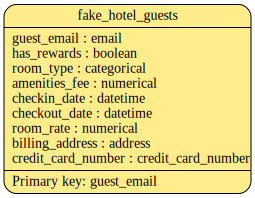

In [ ]:
metadata.visualize()

# 2. Basic Usage

## 2.1 Creating a Synthesizer

An SDV **synthesizer** is an object that you can use to create synthetic data. It learns patterns from the real data and replicates them to generate synthetic data.

In [ ]:
from sdv.single_table import CTGANSynthesizer

synthesizer = CTGANSynthesizer(metadata)
synthesizer.fit(real_data)

<font color="maroon"><i><b>This step takes a few minutes.</b> For larger datasets, this phase may take longer. A drawback of a GAN-based model like CTGAN is performance.</i></font>

When this code finishes running, the synthesizer is ready to use.

## 2.2 Generating Synthetic Data
Use the `sample` function and pass in any number of rows to synthesize.

In [ ]:
synthetic_data = synthesizer.sample(num_rows=500)
synthetic_data.head()

,guest_email,has_rewards,room_type,amenities_fee,checkin_date,checkout_date,room_rate,billing_address,credit_card_number
0,dsullivan@example.net,False,BASIC,14.17,07 Jan 2021,17 Nov 2020,160.21,"90469 Karla Knolls Apt. 781\nSusanberg, CA 70033",5161033759518983
1,steven59@example.org,False,BASIC,12.29,18 Jul 2020,07 Jan 2020,179.43,"6108 Carla Ports Apt. 116\nPort Evan, MI 71694",4133047413145475690
2,brandon15@example.net,True,DELUXE,21.51,07 Jan 2021,05 Oct 2020,183.91,86709 Jeremy Manors Apt. 786\nPort Garychester...,4977328103788
3,humphreyjennifer@example.net,False,BASIC,34.61,27 Jun 2020,08 Jan 2021,250.77,"8906 Bobby Trail\nEast Sandra, NY 43986",3524946844839485
4,joshuabrown@example.net,True,SUITE,NaN,07 Jan 2021,19 Feb 2020,148.42,"732 Dennis Lane\nPort Nicholasstad, DE 49786",4446905799576890978


The synthesizer is generating synthetic guests in the **same format as the original data**.

## 2.3 Evaluating Real vs. Synthetic Data

SDV has built-in functions for evaluating the synthetic data and getting more insight.

As a first step, we can run a **diagnostic** to ensure that the data is valid. SDV's diagnostic performs some basic checks such as:

- All primary keys must be unique
- Continuous values must adhere to the min/max of the real data
- Discrete columns (non-PII) must have the same categories as the real data
- Etc.

In [ ]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 9/9 [00:00<00:00, 528.00it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 101.06it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



<font color="green"><b>The score is 100%</b></font>, indicating that the data is fully valid.

We can also measure the **data quality** or the statistical similarity between the real and synthetic data. This value may vary anywhere from 0 to 100%.

In [ ]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 545.12it/s]|
Column Shapes Score: 78.08%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 193.74it/s]|
Column Pair Trends Score: 74.38%

Overall Score (Average): 76.23%



According to the score, the synthetic data is about 76% similar to the real data in terms of statistical similarity.

We can also get more details from the report. For example, the Column Shapes sub-score is 78%. Which columns had the highest vs. the lowest scores?

In [ ]:
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,has_rewards,TVComplement,0.820000
1,room_type,TVComplement,0.782000
2,amenities_fee,KSComplement,0.762637
3,checkin_date,KSComplement,0.658000
4,checkout_date,KSComplement,0.924230
5,room_rate,KSComplement,0.738000


## 2.4 Visualizing the Data
For more insights, we can visualize the real vs. synthetic data.

Let's perform a 1D visualization comparing a column of the real data to the synthetic data.

In [ ]:
from sdv.evaluation.single_table import get_column_plot

fig = get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_name='room_type',
    metadata=metadata
)

fig.show()

We can also visualize in 2D, comparing the correlations of a pair of columns.

In [ ]:
from sdv.evaluation.single_table import get_column_pair_plot

fig = get_column_pair_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_names=['room_rate', 'room_type'],
    metadata=metadata
)

fig.show()

## 2.5 Anonymization

In the original dataset, we had some sensitive columns such as the guest's email, billing address and phone number. In the synthetic data, these columns are **fully anonymized** -- they contain entirely fake values that follow the format of the original.

PII columns are not included in the quality report, but we can inspect them to see that they are different.

In [ ]:
sensitive_column_names = ['guest_email', 'billing_address', 'credit_card_number']

real_data[sensitive_column_names].head(3)

,guest_email,billing_address,credit_card_number
0,michaelsanders@shaw.net,"49380 Rivers Street\nSpencerville, AK 68265",4075084747483975747
1,randy49@brown.biz,"88394 Boyle Meadows\nConleyberg, TN 22063",180072822063468
2,webermelissa@neal.com,"0323 Lisa Station Apt. 208\nPort Thomas, LA 82585",38983476971380


In [ ]:
synthetic_data[sensitive_column_names].head(3)

,guest_email,billing_address,credit_card_number
0,dsullivan@example.net,"90469 Karla Knolls Apt. 781\nSusanberg, CA 70033",5161033759518983
1,steven59@example.org,"6108 Carla Ports Apt. 116\nPort Evan, MI 71694",4133047413145475690
2,brandon15@example.net,86709 Jeremy Manors Apt. 786\nPort Garychester...,4977328103788


## 2.6 Saving and Loading
We can save the synthesizer to share with others and sample more synthetic data in the future.

In [ ]:
synthesizer.save('my_synthesizer.pkl')

synthesizer = CTGANSynthesizer.load('my_synthesizer.pkl')

# 3. CTGAN Customization
When using this synthesizer, we can make a tradeoff between training time and data quality using the `epochs` parameter: Higher `epochs` means that the synthesizer will train for longer, and ideally improve the data quality.

To see the progress, we can also turn on the `verbose` parameter. This will show a progress bar that will fill up as the synthesizer completes the fit process.


In [ ]:
custom_synthesizer = CTGANSynthesizer(
    metadata,
    epochs=1000,
    verbose=True)
custom_synthesizer.fit(real_data)

Gen. (-0.36) | Discrim. (0.09): 100%|██████████| 1000/1000 [01:30<00:00, 11.10it/s]


<font color="maroon"><i><b>This code takes longer to run.</b></i></font>

After we've trained our synthesizer, we can verify the changes to the data quality by creating some synthetic data and evaluating it.

In [ ]:
synthetic_data_customized = custom_synthesizer.sample(num_rows=500)

quality_report = evaluate_quality(
    real_data,
    synthetic_data_customized,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 9/9 [00:00<00:00, 300.28it/s]|
Column Shapes Score: 85.09%

(2/2) Evaluating Column Pair Trends: |██████████| 36/36 [00:00<00:00, 163.90it/s]|
Column Pair Trends Score: 82.49%

Overall Score (Average): 83.79%



While GANs are able to model complex patterns and shapes, it is not easy to understand how they are learning -- but it is possible to modify the underlying architecture of the neural networks.

For users who are familiar with the GAN architecture, there are extra parameters you can use to tune CTGAN to your particular needs. For more details, see [the CTGAN documentation](https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers/ctgansynthesizer).

# 4. What's Next?

For more information about the CTGAN Synthesizer, visit the **[documentation](https://docs.sdv.dev/sdv/single-table-data/modeling/synthesizers/ctgansynthesizer)**.

**Need more help?** [Browse all tutorials](https://docs.sdv.dev/sdv/demos).

---

# About

The [Synthetic Data Vault Project](https://github.com/sdv-dev/SDV) was first created at MIT's Data to AI Lab in 2016. After 4 years of research and traction with enterprise, we created [DataCebo](https://datacebo.com/) in 2020 with the goal of growing the project. Today, DataCebo is the proud developer of SDV, the largest ecosystem for tabular synthetic data generation & evaluation.

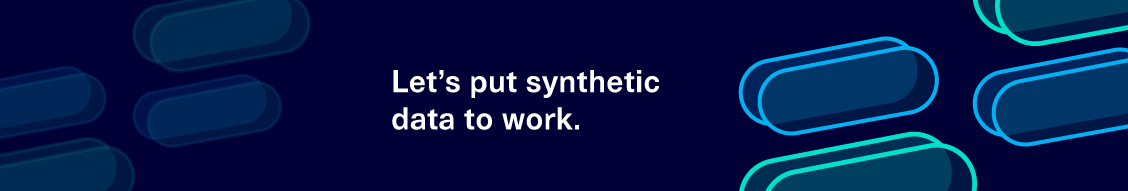